In [125]:
%matplotlib inline
import torch
import os,sys
import numpy as np
import torchvision.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, random_split, DataLoader
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# *Set up environment* 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True, use_metadata_server=False)

Mounted at /content/drive


In [83]:
def import_file(url, filename):
  import requests
  r = requests.get(url)

  with open(filename, 'w') as f:
        f.write(r.text)

if "google.colab" in sys.modules:
    # Save datagenerators as file to colab working directory
    # If you are using GitHub, make sure you get the "Raw" version of the code
    url_u_net = 'https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/models/u_net.py?token=AJVSYDHQIQ5KJXR6G5EH6NS7275YE'
    import_file(url_u_net, 'u_net.py')

    url_u_net_paper = 'https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/models/u_net_paper.py?token=AJVSYDDDE2ZOO2E5RKHSDNK7275ZI'
    import_file(url_u_net_paper, 'u_net_paper.py')

    url_training = 'https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/training.py?token=AJVSYDBUQJXHKKCMQZTOC3272752S'
    import_file(url_training, 'training.py')

    url_image_mask_dataset = "https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/image_mask_dataset.py?token=AJVSYDEYVNI34EBZZW6QMPK72753U"
    import_file(url_image_mask_dataset, 'image_mask_dataset.py')

    url_losses = "https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/losses.py?token=AJVSYDGGYYFBALHBYGZQM4S727546"
    import_file(url_losses, 'losses.py')

    url_mask_to_submission = "https://raw.githubusercontent.com/karimassi/road-segmentation/main/src/scripts/mask_to_submission.py?token=AH35XE53LAD2Y6Y4NC4JCAC73DHIA"
    import_file(url_mask_to_submission, 'mask_to_submission.py')

    url_helpers = "https://raw.githubusercontent.com/karimassi/road-segmentation/u_net/src/scripts/helpers.py?token=AJVSYDE2Y2IE7SXUHND5X2K73KW4K"
    import_file(url_helpers, 'helpers.py')
        
    import u_net
    import u_net_paper 
    import training
    import image_mask_dataset
    import losses
    from mask_to_submission import masks_to_submission
    import helpers
else:
    from src import u_net
    from src import u_net_paper
    from src import training
    from src import image_mask_dataset
    from src import losses
    from src import helpers

[autoreload of image_mask_dataset failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


# **Load data**

In [147]:
# load data
from image_mask_dataset import ImageMaskDataset

root_dir = "/content/drive/Shareddrives/road-segmentation/data/"
image_dir = root_dir + "training/images/"
gt_dir = root_dir + "training/groundtruth/"
test_dir = root_dir + "test_set_images/"

# TODO change implementation of this dataset
dataset = ImageMaskDataset(image_dir, gt_dir)

# data augmentation
angles = [15, -10, 45, -60, 78]
for angle in angles:
    rotation = lambda img: TF.rotate(img, angle)
    dataset += ImageMaskDataset(image_dir, gt_dir, rotation)

shears = [[15, 20], [10, 30], [30, -17], [-3, 20], [-5, -10]]
for shear in shears:
  transformation = lambda img: TF.affine(img, angle=0, scale=1.0, translate=[0, 0], shear=shear)
  dataset += ImageMaskDataset(image_dir, gt_dir, transformation)

print(len(dataset))

9900


In [148]:
num_epochs = 10
learning_rate = 1e-3
batch_size = 5

data_len = len(dataset)
train_len = int(data_len * 0.8)
test_len = int(data_len * 0.2)

dataset_train, dataset_test = random_split(dataset, [train_len, test_len])
print(len(dataset_train), len(dataset_test))

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=True
)

7920 1980


# ***Train model***

In [149]:
import u_net_paper
from u_net_paper import UNet_paper

NUM_CHANNELS = 3
NUM_FILTERS = 64

model = UNet_paper(NUM_CHANNELS, NUM_FILTERS).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#loading_model_file = "u_net_120.pkt"

#if loading_model_file in os.listdir():
#    print("Loading model from " + loading_model_file)
#    model.load_state_dict(torch.load(loading_model_file))

In [150]:
import training

# Train the u-net model with SGD optimizer
criterion = losses.Dice()

training.train(model, criterion, dataloader_train, dataloader_test, optimizer, num_epochs)

#from torchsummary import summary
#summary(model, input_size=(NUM_CHANNELS, 400, 400))

Starting training
Epoch  1 | Test accuracy : 0.44241 | Test F1 : 0.52857 | In 46.80059099197388 s
Epoch  2 | Test accuracy : 0.44241 | Test F1 : 0.55578 | In 46.755337953567505 s
Epoch  3 | Test accuracy : 0.44241 | Test F1 : 0.55951 | In 46.78163981437683 s
Epoch  4 | Test accuracy : 0.44241 | Test F1 : 0.56085 | In 46.71970868110657 s
Epoch  5 | Test accuracy : 0.44241 | Test F1 : 0.56143 | In 46.767712116241455 s
Epoch  6 | Test accuracy : 0.44241 | Test F1 : 0.56185 | In 46.74223828315735 s
Epoch  7 | Test accuracy : 0.44241 | Test F1 : 0.56225 | In 46.74394750595093 s
Epoch  8 | Test accuracy : 0.44241 | Test F1 : 0.56254 | In 46.79447531700134 s
Epoch  9 | Test accuracy : 0.44241 | Test F1 : 0.56284 | In 46.798694372177124 s
Epoch  10 | Test accuracy : 0.44241 | Test F1 : 0.56299 | In 46.73372483253479 s


In [163]:
torch.save(model.state_dict(), "u_net_10.pkt")

### Show predicted output

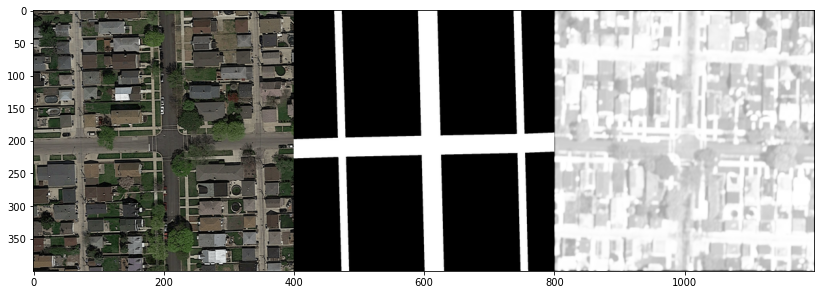

In [162]:
i = 0

files = os.listdir(image_dir)
img = mpimg.imread(image_dir + files[i])
gt = mpimg.imread(gt_dir + files[i])
output = model(torch.tensor(img).to(device).permute(2, 1, 0).view(1, 3, 400, 400))
prediction = output[0][0].cpu().detach().numpy()

from helpers import concatenate_images
fig1 = plt.figure(figsize=(14, 10))
plt.imshow(concatenate_images(concatenate_images(img, gt), prediction))

# **Predict output for testing images**

In [ ]:
import image_mask_dataset
submission_dataloader = DataLoader(
    image_mask_dataset.FullSubmissionImageDataset(test_dir),
    batch_size=1
)

In [ ]:
model.eval()
toPIL = transforms.ToPILImage()

output_dir = "outputs"

if output_dir not in os.listdir():
    os.makedirs(output_dir)

for indexes, images in submission_dataloader:
    out = model(images.to(device)).view(2, 608, 608).cpu()
    toPIL(out[0]).save(output_dir + "/file_{:03d}.png".format(indexes.view(-1).item()))

In [ ]:
masks_to_submission("submission.csv", *[output_dir + "/" + f for f in os.listdir(output_dir)])